![](images/person-holds-a-basket-full-of-groceries-in-a-supermarket.jpg)

In this project I used the K-means algorithm to cluster grocery items based on their transaction data.

**Items that are often purchases together can be placed in the same aisle or aisles closer to each other,
increasing sales!**

This used to be done by human experts, which would require **many years of experience** in the industry to
narrow things down. However, with the rise of big data and machine learning, why not
let AI do all the trick and hard work for you?

Ok let's get started. The first step is to gather the dataset. Here I downloaded
[the Instacart dataset](https://www.kaggle.com/c/instacart-market-basket-analysis/data)
from Kaggle, and **filtered out items that don't have a sufficient purchase history** yet in the dataset
(being purchased fewer than 100 times), because they may not contain enough information to be correctly
classified(i.e. they may end up forming weird 1-item categories).

In [1]:
# Load dependencies
import pandas as pd
from scipy import sparse
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 30)

# Load the Instacart data and cluster items that have been purchased at least 100 times
df = pd.read_csv('data/order_products__train.csv')
df = df.drop(['add_to_cart_order', 'reordered'], axis=1)
df = df.groupby('product_id').filter(lambda x:len(x) >= 100)

df_products = pd.read_csv('data/products.csv')
df_aisles = pd.read_csv('data/aisles.csv')

The main table is pretty straightforward, classical order_id - product_id pairs.

In [2]:
df.head()

,order_id,product_id
1,1,11109
2,1,10246
3,1,49683
5,1,13176
6,1,47209


Now let's transform the order data into a matrix where:
- each row is an order
- each column is a product
- each value 1 indicates a purchase

In [3]:
df['filler'] = 1
df = df.pivot(index='order_id', columns='product_id', values='filler').fillna(0)

In [19]:
df.head()

product_id,10,34,45,79,95,116,117,130,141,160,...,49481,49517,49520,49533,49585,49605,49610,49621,49628,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Number of Transactions:', df.shape[0])
print('Number of Items:', df.shape[1])

Number of Transactions: 125956
Number of Items: 2457


Cool, now that everything has been set up, let's transform the data into a **similarity matrix**.
(here I used the cosine similarity, but other metrics should be fine).

Essentially, items that are often purchased together will have a similarity of 1, whereas
those that have never been purchased together will have a similarity of 0.

In [5]:
# Save memories by converting it to a sparse matrix
data = df.to_numpy()
data_sparse = sparse.csr_matrix(data)
data_clustering = metrics.pairwise.cosine_similarity(data_sparse.T)
data_clustering = sparse.csr_matrix(data_clustering)

Then, time to apply the K-means algorithm using the similarity matrix we just obtained!

How do we choose K though? It's usually more subject to the business requirements.

However, here what we can do is to pick a bunch of Ks and look at the inertia plot.

A range between 100 and 200 would probably be a good start since we don't want to make things too complicated.
(which works out to be around 10+ types of item per aisle)

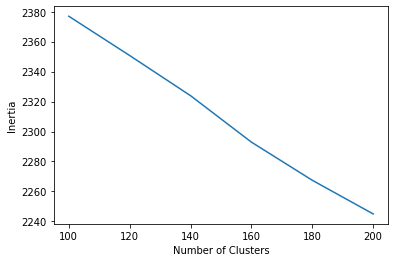

In [7]:
cluster_inertia = []
for i in range(100, 220, 20):
    model = KMeans(n_clusters=i)
    model.fit(data_clustering)
    cluster_inertia.append(model.inertia_)

plt.plot(range(100, 220, 20), cluster_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

According to the plot, 200 seems to be a good choice since the line keeps going down.

Let's plug it in!

In [30]:
kmeans = KMeans(n_clusters=200)

clusters = kmeans.fit_predict(data_clustering)
final_clusters = pd.DataFrame({'cluster':clusters,
                               'product_id':df.columns})
df_cluster = final_clusters.sort_values('cluster')
df_cluster = pd.merge(df_cluster, df_products, how='left', on='product_id')
df_cluster = df_cluster.drop(['aisle_id', 'department_id'], axis=1)

In [31]:
df_cluster

,cluster,product_id,product_name
0,0,31964,Passionfruit Sparkling Water
1,0,49520,Orange Sparkling Water
2,0,49191,Cran Raspberry Sparkling Water
3,1,5883,Organic Strawberry Lemonade
4,1,8929,Organic Chicken Pot Pie
...,...,...,...
2452,199,32747,Low Fat 1% Milk
2453,199,45116,Potatoes Sweet
2454,199,40354,California Clementines
2455,199,7419,Sweet Red Grape Tomatoes


Get some basic stats regarding our clusters.

/Users/ree/PycharmProjects/Personal/grocery-item-clustering/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cluster', ylabel='Density'>

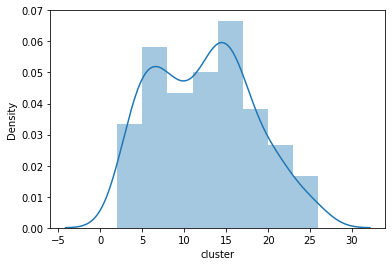

In [32]:
sns.distplot(df_cluster['cluster'].value_counts())

The group counts seem quite reasonable. Let's inspect some of the categories manually!

In [33]:
df_cluster.query('cluster == 1')

,cluster,product_id,product_name
3,1,5883,Organic Strawberry Lemonade
4,1,8929,Organic Chicken Pot Pie
5,1,28769,Organic Apple Chicken Sausage
6,1,29370,Organic White Cheddar Popcorn
7,1,16363,Gluten Free Breaded Chicken Breast Tenders
8,1,37971,Organic Cranberry Pomegranate Juice
9,1,35383,Classic White Bread
10,1,45957,Peach Mango Salsa
11,1,30967,Organic Frosted Flakes Cereal
12,1,13640,Asian Pears


In [34]:
df_cluster.query('cluster == 2')

,cluster,product_id,product_name
17,2,17429,Jalapeno Hummus
18,2,39475,Total Greek Strained Yogurt
19,2,5479,Italian Sparkling Mineral Water
20,2,10017,Tilapia Filet
21,2,21543,Organic Quick Oats
22,2,16521,Walnut Halves & Pieces
23,2,16083,Organic Large Brown Eggs
24,2,45965,Steel Cut Oats
25,2,31869,Organic Edamame
26,2,19660,Spring Water


In [35]:
df_cluster.query('cluster == 3')

,cluster,product_id,product_name
34,3,27398,Genuine Chocolate Flavor Syrup
35,3,12099,Honey Greek Yogurt
36,3,36994,Organic Graham Crunch Cereal
37,3,38563,Mint Chocolate Chip Ice Cream
38,3,32156,Cranberry Juice Cocktail
39,3,40486,Chicken Tenders
40,3,35199,100% Apple Juice
41,3,30597,French Vanilla Coffee Creamer
42,3,15780,Breakfast Blend Medium Roast Ground Coffee
43,3,43889,Dark Chocolate Covered Banana


Voila!
- For cluster 1 I cannot seem to find an obvious category, but apparently they are often bought together!
- Cluster 2 seems to be **healthy/organic food**
- Cluster 3 seems to be **sweet, breakfast and coffee stuff**